### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

### Uploaded the Database

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/BuildWeekAirbnbOptimal2/Datascience/master/Berlin.csv')
print(df.shape)
df.head()

(22552, 96)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,t,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.25
3,3309,https://www.airbnb.com/rooms/3309,20181107122246,2018-11-07,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.39
4,7071,https://www.airbnb.com/rooms/7071,20181107122246,2018-11-07,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,none,"Great neighborhood with plenty of Cafés, Baker...",...,t,NaN,NaN,f,f,moderate,f,f,1,1.75


### Target Distribution

In [3]:
#how the sale price is distributed
y = df['price']
y.describe()

count      22552
unique       295
top       $30.00
freq        1387
Name: price, dtype: object

In [4]:
#Remove symbols from price string and convert to float
df['price']= (df['price'].str.replace('$','')
              .str.replace(',', '')
              .astype(float))
df['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

In [5]:
# Maximum sale price is 9000 and mini price is $0
# From this skewed distribution it looks like an outlier
#Remove the outlier  most extreme 1% prices
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99))]


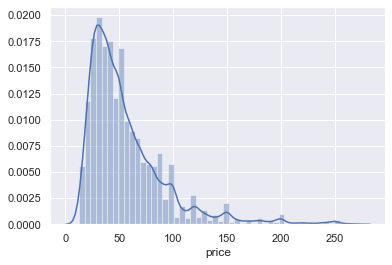

In [6]:
%matplotlib inline
sns.set()
sns.distplot(df['price'])

###  Mean Baseline Model

In [7]:
#On average listing in Berline sold for $56
df['price'].describe()

count    22234.000000
mean        56.280426
std         37.042403
min         13.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        270.000000
Name: price, dtype: float64

In [8]:
#calculating the accuracy of the majority class
y = df['price']
majority_class= df['price'].mean()
y_pred = [majority_class]* len(y)
len(y_pred)

22234

In [9]:
from sklearn.metrics import mean_absolute_error, r2_score
print('R^2 score', r2_score(y, y_pred))
# calculate mean absolute error
mae = mean_absolute_error(y, y_pred)
print(f'MAE : {mae:.0f}')

R^2 score 0.0
MAE : 26


### clean and explore data

In [10]:
# Total no. of columns in data
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [11]:
pd.options.display.max_columns=97
df.describe(include='all')

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,2.223400e+04,22234,2.223400e+04,22234,22176,21312,13816,22037,22234,11391,7095,12882,10698,10231,11273,0.0,0.0,22234,0.0,2.223400e+04,22234,22210,22210,22121,11007,9503,9502,0.0,22210,22210,22210,17219,22210.000000,22210.000000,22234,22210,22210,22234,21114,22234,22234,22229,22156,21584,22172,22234,22234,22234,22234.000000,22234.000000,22234,22234,22234,22234.000000,22202.000000,22216.000000,22197.000000,22234,22234,441.000000,22234.000000,3663,2643,12999,15229,22234.000000,22234,22234.000000,2.223400e+04,22234,22234,22234.000000,22234.000000,22234.000000,22234.000000,22234,22234.000000,18427,18433,17961.000000,17936.000000,17939.000000,17918.000000,17932.000000,17919.000000,17915.000000,22234,1575,0.0,22234,22234,22234,22234,22234,22234.000000,18427.000000
unique,NaN,22234,NaN,2,21567,20787,13429,21719,1,10675,6605,12192,9838,9477,10233,NaN,NaN,22150,NaN,NaN,19014,5949,2914,1028,8811,4,64,NaN,2,18936,18936,180,NaN,NaN,300,2,2,85,91,136,12,59,19,213,6,60,1,1,NaN,NaN,2,33,3,NaN,NaN,NaN,NaN,5,19720,NaN,NaN,377,418,141,107,NaN,63,NaN,NaN,75,1,NaN,NaN,NaN,NaN,2,NaN,2224,1307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1356,NaN,2,1,5,2,2,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/23992001,NaN,2018-11-07,Berlin Wohnung,"with en-suite bathroom, TV, WIFI, bed linen, a...",The Singer 109 Hostel is located in the heart ...,We are located in one of the most colorful dis...,none,Welcome Traveler. The Singer Hostel and Apart...,Since 01.01.2014 the city of Berlin had to ado...,U-Bahn / Underground /Subway / Metro: U5 (Stra...,We can offer our guests - Pool table/Snooker -...,There is always at least 1 member of staff on ...,- No shoes in the house,NaN,NaN,https://a0.muscache.com/im/pictures/e62cc6e1-c...,NaN,NaN,https://www.airbnb.com/users/show/1625771,Anna,2017-02-20,"Berlin, Berlin, Germany",.,within an hour,100%,NaN,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Neukölln,NaN,NaN,"['email', 'phone', 'reviews']",t,f,"Berlin, Berlin, Germany",Neukölln,Tempelhofer Vorstadt,Friedrichshain-Kreuzberg,Berlin,Berlin,10245,Berlin,"Berlin, Germany",DE,Germany,NaN,NaN,t,Apartment,Private room,NaN,NaN,NaN,NaN,Real Bed,{},NaN,NaN,$300.00,"$1,200.00",$0.00,$0.00,NaN,$0.00,NaN,NaN,today,t,NaN,NaN,NaN,NaN,2018-11-07,NaN,2017-05-28,2018-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,HRB155306B,NaN,f,f,flexible,f,f,NaN,NaN
freq,NaN,1,NaN,22231,14,14,41,12,22234,43,37,26,42,43,30,NaN,NaN,3,NaN,NaN,45,213,51,16954,70,4999,7027,NaN,19258,56,56,2541,NaN,NaN,4053,22154,13597,22031,3195,1310,5430,22121,2211

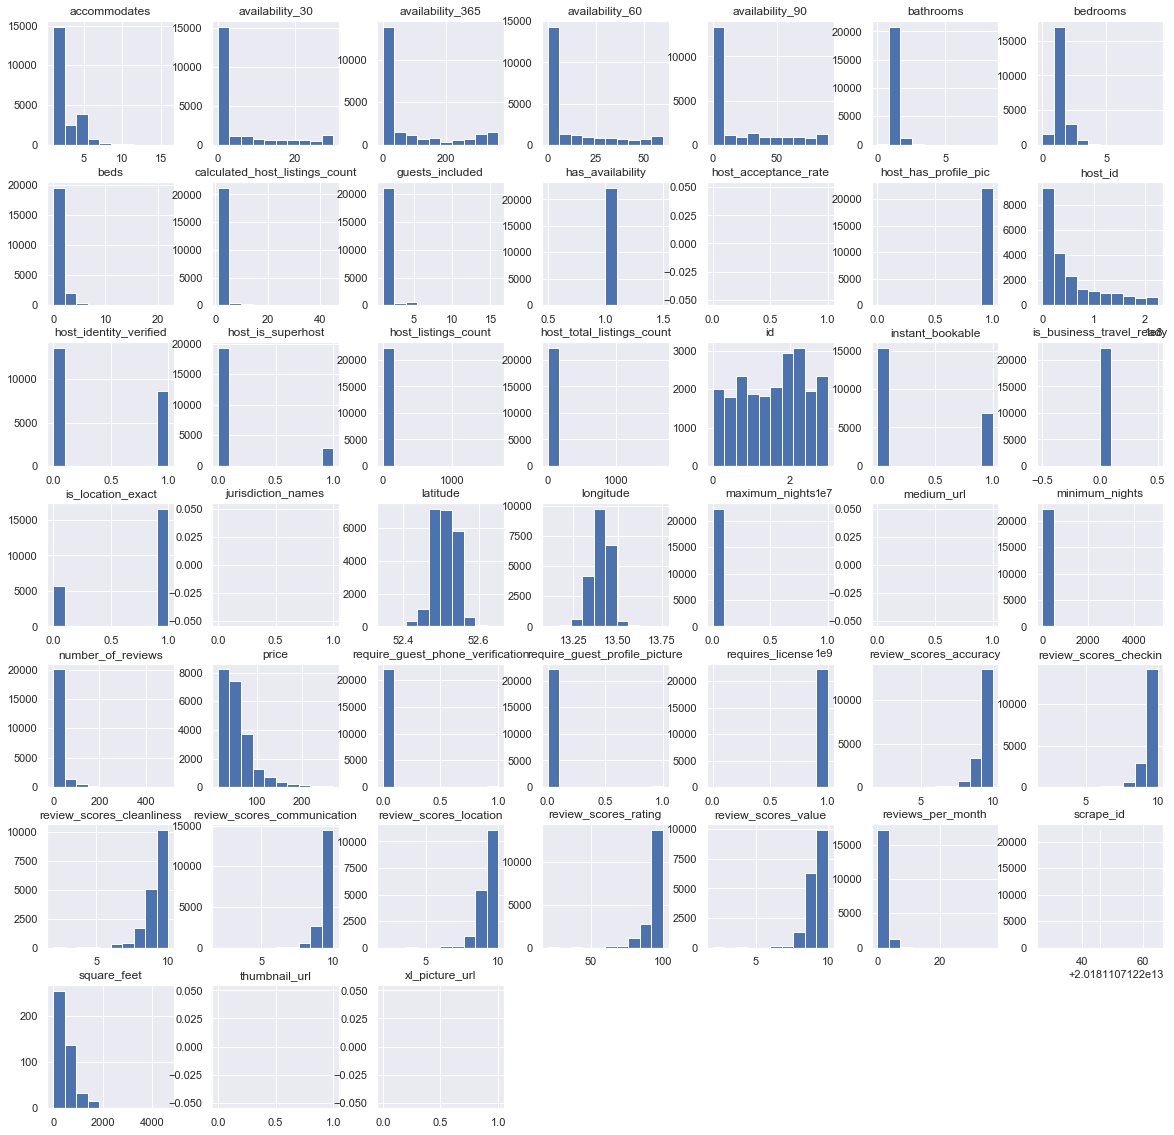

In [12]:
#Replacing columns values f/t to 1/0
df.replace({'f':0, 't':1}, inplace =True)
#Plotting the distribution of numerical data
df.hist(figsize=(20, 20));

From the above graphs the columns that contains only one categorey can be drop

In [13]:
#Drop the high cardinality columns
# and columns which are not useful for predicting price
#(e.g. url, host name and other host and guest related features that are unrelated to the property).

cols_to_drop = ['listing_url','experiences_offered', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
                'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules',
                'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
                'host_name', 'host_location', 'host_since','host_is_superhost','host_has_profile_pic','host_about',
                'host_thumbnail_url','host_picture_url', 'host_neighbourhood', 'host_verifications',
                'calendar_last_scraped','require_guest_profile_picture', 'require_guest_phone_verification',
                'is_business_travel_ready','requires_license','bed_type','property_type','has_availability']
df = df.drop(columns= cols_to_drop)

In [14]:
# calculating the missing values in data
pd.set_option('display.max_rows', 100)
df.isna().sum()

id                                    0
host_response_time                12731
host_response_rate                12732
host_acceptance_rate              22234
host_listings_count                  24
host_total_listings_count            24
host_identity_verified               24
street                                0
neighbourhood                      1120
neighbourhood_cleansed                0
neighbourhood_group_cleansed          0
city                                  5
state                                78
zipcode                             650
market                               62
smart_location                        0
country_code                          0
country                               0
latitude                              0
longitude                             0
is_location_exact                     0
room_type                             0
accommodates                          0
bathrooms                            32
bedrooms                             18


In [15]:
#drop the columns that contains majority of null values
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 
         'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)
#df=df.reset_index(drop=True)

There are multiple columns for property location, some of these columns can be dropped.Because all of the listings are in Berline, column related to city and country can be dropped

In [16]:
df.drop(['street', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country'], axis=1, inplace=True)

### Explore indivisual columns

In [17]:
#Both columns are same so one of the columns can be drop
df[['host_listings_count', 'host_total_listings_count']].describe()

,host_listings_count,host_total_listings_count
count,22210.000000,22210.000000
mean,2.305583,2.305583
std,20.080650,20.080650
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,1676.000000,1676.000000


In [18]:
df.drop(['host_total_listings_count'], axis=1, inplace=True)

In [19]:
#totol no. of columns left
print(df.shape)
df.columns

(22234, 42)


Index(['id', 'host_response_time', 'host_response_rate', 'host_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'is_location_exact', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

#### Availability
There are multiple different measures of availability, which will be highly correlated with each other,so Only one will be retained - for 90 days because AirBnb guests probabily look for short-term 
booking.

In [20]:
df[['availability_30', 'availability_60', 'availability_90','availability_365']].describe()

,availability_30,availability_60,availability_90,availability_365
count,22234.000000,22234.000000,22234.000000,22234.000000
mean,4.845192,10.953315,19.720473,78.678690
std,8.578793,17.341957,28.105538,118.438207
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,3.000000
75%,6.000000,17.000000,35.000000,126.000000
max,30.000000,60.000000,90.000000,365.000000


In [21]:
df.drop(['availability_30', 'availability_60','availability_365'], axis=1, inplace=True)

#### Review scores

In [22]:
#'reviews_per_month' will be highly correlated with number_of_reviews and so will be dropped.
df.drop(['reviews_per_month'], axis=1, inplace=True)

In [23]:
df[['review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location','review_scores_value']].describe()

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,17936.000000,17939.000000,17918.000000,17932.000000,17919.000000,17915.000000
mean,9.666369,9.324879,9.713528,9.730984,9.506781,9.413452
std,0.734340,1.031033,0.705765,0.687300,0.761595,0.839416
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000
50%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Almost 20% of the listings have missing review score, replacing this portion of data with simply mean/median would skewed the distrbution significantly .This is a large  proportion of the dataset to drop, and dropping the columns would lose a lot of useful information about new listing that haven't had review yet.

In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is actually beneficial to keep them in. Therefore, these will be kept as an unknown category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical, because reviews are very important in people's decisions to book, and therefore price.



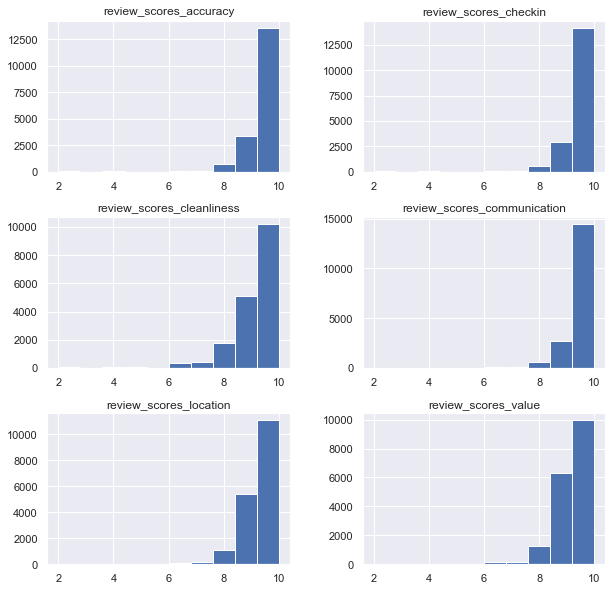

In [24]:
#Distribution of the review score columns
review_score = df[[ 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].hist(figsize=(10, 10));

Majority of rating scores are 9 or 10 out of 10, therefore for these columns 9 and 10 will be kept as a seperate group and 1-8/10 will be binned together



In [25]:
def get_binvalue(df, columns, bins, labels, na_label='unknown'):
    '''Return the columns of the dataframe into bins 
        and replace the null values(with 'unknown' if unspecified) '''
    for col in columns:
        df[col] = pd.cut(x=df[col], bins=bins, labels=labels)
        df[col] = df[col].astype('str')
        df[col].fillna(na_label, inplace= True)
         

In [26]:
columns = ['review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']
get_binvalue(df,columns, bins=[0,8, 9, 10], labels=['low', 'Medium', 'High'], na_label='No Reviwes')

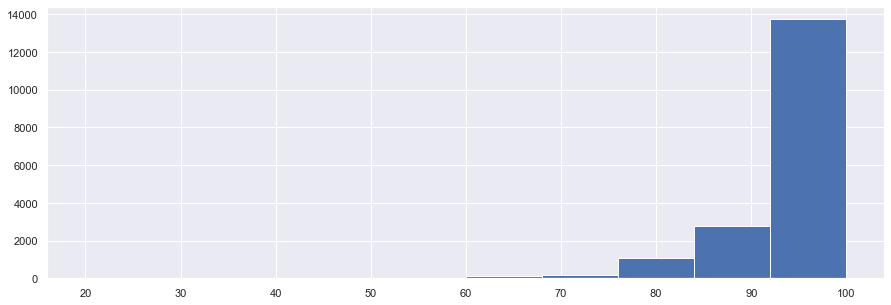

In [27]:
# Distribution of the review_score_rating
df.review_scores_rating.hist(figsize=(15,5));

In [28]:
df['review_scores_rating'].value_counts()

100.0    5974
98.0     1255
96.0     1210
97.0     1210
95.0     1099
93.0     1068
90.0     1002
80.0      838
99.0      685
94.0      665
92.0      553
91.0      434
87.0      351
89.0      332
88.0      287
85.0      150
86.0      127
84.0      115
60.0      115
83.0       84
70.0       70
82.0       40
73.0       36
75.0       30
40.0       29
77.0       28
78.0       28
76.0       27
81.0       26
20.0       25
67.0       19
79.0       11
50.0        7
72.0        6
74.0        5
69.0        4
71.0        3
68.0        2
65.0        2
63.0        2
64.0        2
57.0        1
30.0        1
56.0        1
33.0        1
53.0        1
Name: review_scores_rating, dtype: int64

In [29]:
# Binning column scored out of 100
get_binvalue(df,columns=['review_scores_rating'],
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='No Reviews')

In [30]:
df.drop(columns=['id'], axis=1, inplace =True)

### Location

In [31]:
#Most of the listing has exact location
df['is_location_exact'].value_counts()

1    16551
0     5683
Name: is_location_exact, dtype: int64

In [32]:
df.drop(['is_location_exact'], axis=1, inplace =True)

In [33]:
df[['neighbourhood','neighbourhood_cleansed', 'latitude', 'longitude']]

,neighbourhood,neighbourhood_cleansed,latitude,longitude
0,Mitte,Brunnenstr. Süd,52.534537,13.402557
1,NaN,Prenzlauer Berg Nordwest,52.548513,13.404553
2,Prenzlauer Berg,Prenzlauer Berg Südwest,52.534996,13.417579
3,Schöneberg,Schöneberg-Nord,52.498855,13.349065
4,Prenzlauer Berg,Helmholtzplatz,52.543157,13.415091
...,...,...,...,...
22547,Mitte,Brunnenstr. Süd,52.533865,13.400731
22548,Schöneberg,Schöneberg-Nord,52.496211,13.341738
22549,Prenzlauer Berg,Prenzlauer Berg Südwest,52.531800,13.411999
22550,Mitte,Alexanderplatz,52.520802,13.378688


### Security Deposite

In [34]:
df['security_deposit'].describe()

count     12999
unique      141
top       $0.00
freq       5265
Name: security_deposit, dtype: object

In [35]:
#82% of values are either zero or missing,so we can drop this column
print('Percentage of  Missing and zero values in security deposite',(12999+5265)/22234*100)
df.drop(['security_deposit'], axis=1, inplace=True)

Percentage of  Missing and zero values in security deposite 82.14446343437977


#### host_response_time

In [36]:
df['host_response_time'].value_counts()

within an hour        4999
within a few hours    2088
within a day          2037
a few days or more     379
Name: host_response_time, dtype: int64

In [37]:
#Because host_response_time is unknown for so many listings,
#it will be retained as its own category, 'unknown'
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.572592
within an hour        0.224836
within a few hours    0.093910
within a day          0.091616
a few days or more    0.017046
Name: host_response_time, dtype: float64

### host_response_rate

In [38]:
df['host_response_rate'].value_counts()

100%    7027
90%      478
80%      304
50%      195
0%       193
70%      127
67%      113
60%       95
75%       92
83%       83
89%       68
86%       66
88%       62
97%       53
33%       42
92%       34
94%       33
40%       33
78%       27
91%       25
98%       24
95%       23
96%       21
71%       21
93%       21
57%       19
20%       19
30%       19
25%       18
82%       15
63%       14
84%       14
74%       11
81%        8
38%        8
19%        8
56%        7
29%        6
17%        6
87%        6
44%        5
85%        5
43%        4
79%        4
46%        4
54%        4
77%        4
73%        3
68%        3
52%        3
64%        3
22%        3
69%        3
18%        2
10%        2
48%        2
14%        2
65%        2
62%        1
72%        1
55%        1
58%        1
76%        1
13%        1
Name: host_response_rate, dtype: int64

In [39]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

In [40]:
# Binned into 5 categories include Nan values with its category
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

unknown    12732
100%        7027
50-89%      1669
0-49%        572
90-99%       234
Name: host_response_rate, dtype: int64

In [41]:
print(df.shape)
df.columns

(22234, 35)


Index(['host_response_time', 'host_response_rate', 'host_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_90', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'calculated_host_listings_count'],
      dtype='object')

In [42]:
df['host_response_time'].value_counts(normalize=True)

unknown               0.572592
within an hour        0.224836
within a few hours    0.093910
within a day          0.091616
a few days or more    0.017046
Name: host_response_time, dtype: float64

In [43]:
df['host_response_rate'].value_counts(normalize=True)

unknown    0.572637
100%       0.316047
50-89%     0.075065
0-49%      0.025726
90-99%     0.010524
Name: host_response_rate, dtype: float64

In [44]:
#Almost 80% of the date in both columns has same distribution
#Which will be highly correlated,so one of the columns can be dropped
df.drop(columns=['host_response_time'], axis=1, inplace=True)

#### bathrooms, bedrooms and beds

In [45]:
df[['room_type','accommodates', 'bathrooms', 'bedrooms', 'beds']].describe()

,accommodates,bathrooms,bedrooms,beds
count,22234.000000,22202.000000,22216.000000,22197.000000
mean,2.603760,1.086299,1.147326,1.599225
std,1.415662,0.310627,0.610391,1.117665
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000
50%,2.000000,1.000000,1.000000,1.000000
75%,3.000000,1.000000,1.000000,2.000000
max,16.000000,8.500000,9.000000,22.000000


In [46]:
#Missing values will be replaced with the median
df= df.copy()
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [47]:
#beds 22 looks like an outlier
df.query('beds==22')

,host_response_rate,host_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_90,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count
18482,100%,1.0,0.0,NaN,Tempelhofer Vorstadt,52.49384,13.419914,Private room,4,3.0,9.0,22.0,"{Wifi,Breakfast,Heating,""Family/kid friendly"",...",50.0,$0.00,1,$35.00,2,1125,2 days ago,90,1,2018-08-14,2018-08-14,95-100/100,High,High,High,High,High,High,0,strict_14_with_grace_period,1


In [48]:
#remove the outlier
df = df[df['beds'] <22]

In [49]:
#Most of the listings has either beds 1 or 2
#binned the beds in two category
df['beds']= pd.cut(x=df['beds'], bins=[0,1,17], labels=['1', '2+'],include_lowest=True )
df['beds']=df['beds'].astype('str')

In [50]:
df['beds'].value_counts()

1     14268
2+     7965
Name: beds, dtype: int64

In [51]:
df['bedrooms'].value_counts()

1.0    17026
2.0     2926
0.0     1470
3.0      664
4.0      120
5.0       19
6.0        5
8.0        2
7.0        1
Name: bedrooms, dtype: int64

In [52]:
#Most of the listings has either bedrooms 1 or 2
#binned the bedrooms in two category
df['bedrooms']= pd.cut(x=df['bedrooms'], bins=[0,1,8], labels=['1', '2+'],include_lowest=True )
df['bedrooms']=df['bedrooms'].astype('str')

In [53]:
df['bedrooms'].value_counts()

1     18496
2+     3737
Name: bedrooms, dtype: int64

In [54]:
df['bathrooms'].value_counts()

1.0    19677
2.0     1181
1.5     1129
0.5      101
2.5       62
3.0       34
0.0       31
4.0        7
8.5        3
7.5        2
8.0        2
7.0        2
3.5        1
5.0        1
Name: bathrooms, dtype: int64

In [55]:
#Most of the listings has either bathrooms 1 or 2
#binned the bathrooms in two category
df['bathrooms']= pd.cut(x=df['bathrooms'], bins=[0,1,10], labels=['1', '2+'],include_lowest=True )
df['bathrooms']=df['bathrooms'].astype('str') 

In [56]:
df['bathrooms'].value_counts()

1     19809
2+     2424
Name: bathrooms, dtype: int64

In [57]:
df['accommodates'].value_counts()

2     12149
4      3178
1      2683
3      2476
5       689
6       681
8       134
7       119
10       46
9        32
12       18
11       13
16        6
15        4
14        3
13        2
Name: accommodates, dtype: int64

In [58]:
#Most of the listings has either bathrooms 1 or 2
#binned the bathrooms in two category
df['accommodates']= pd.cut(x=df['accommodates'], bins=[0,1,2,3,4,17], labels=['1', '2','3','4','4+'],include_lowest=True)
df['accommodates']=df['accommodates'].astype('str')

In [59]:
df['accommodates'].value_counts()

2     12149
4      3178
1      2683
3      2476
4+     1747
Name: accommodates, dtype: int64

### cleaning fee

In [60]:
df[['cleaning_fee','extra_people']].describe()

,cleaning_fee,extra_people
count,15228,22233
unique,107,63
top,$0.00,$0.00
freq,1829,10671


In [61]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

In [62]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

In [63]:
#df2= df.copy()
df['neighbourhood'].describe()

count        21114
unique          91
top       Neukölln
freq          3195
Name: neighbourhood, dtype: object

In [64]:
# Replace nulls with 'unknown'
df['neighbourhood'].fillna('unknown', inplace=True)

In [65]:
df.drop(columns=['first_review', 'last_review'], axis=1, inplace=True)

In [66]:
df.fillna(df.median(),inplace=True)
df = df.reset_index(drop=True)
df.isna().sum()

host_response_rate                0
host_listings_count               0
host_identity_verified            0
neighbourhood                     0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities                         0
price                             0
cleaning_fee                      0
guests_included                   0
extra_people                      0
minimum_nights                    0
maximum_nights                    0
calendar_updated                  0
availability_90                   0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location      

#### Train/Test Split

In [67]:
#Split the data into train and test
train, test = train_test_split(df, train_size = 0.80, test_size= 0.20, random_state= 42)
train.shape, test.shape

((17786, 32), (4447, 32))

In [68]:
target = 'price'
features = train.drop(columns= target).columns
#features= imp_columns
X_train= train[features]
y_train = train[target]

X_test = test[features]
y_test= test[target]
X_train.shape, X_test.shape

((17786, 31), (4447, 31))

In [70]:
def engineer_features(X):

    # Avoid SettingWithCopyWarning
    X = X.copy()
    
    target = 'price'
    features = train.drop(columns= target).columns
    #features = imp_columns
    X_train= train[features]
    y_train = train[target]

    X_test = test[features]
    y_test= test[target]

    # Total number of rooms (beds + baths)
    #X['Total_rooms'] = X['bedrooms'] + X['bathrooms']
    #beds and bedrooms will be highly correlated
    #drop beds columns
    
    #X= X.drop(columns=['beds'])
#     scores = ['review_scores_accuracy',
#        'review_scores_cleanliness', 'review_scores_checkin',
#        'review_scores_communication', 'review_scores_location',
#        'review_scores_value']
     # Reset index
     #X = X.drop()
    X = X.reset_index(drop=True)

    return X

X_train = engineer_features(X_train)
X_test = engineer_features(X_test)
X_train.shape, X_test.shape, 

((17786, 31), (4447, 31))

### Basline linear Model

In [71]:
lr = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Training Accuracy', lr.score(X_train, y_train))
k = 5
LRscores = cross_val_score(lr, X_train, y_train, cv=k, scoring = 'neg_mean_absolute_error')
print(f' MAE for {k} folds:', -LRscores.mean())
y_pred =lr.predict(X_test)
print('Linear Regression R^2:', r2_score(y_test, y_pred))

Training Accuracy 0.45843160320547843
 MAE for 5 folds: 36.986283454178036
Linear Regression R^2: 0.45748812510314707


In [72]:
# lr_model =lr.named_steps['linearregression']
# lr_encoder = lr.named_steps['ordinalencoder']
# encoded_columns =lr_encoder.transform(X_train).columns
# coefficients = pd.Series(lr_model.coef_[0], encoded_columns)
# plt.figure(figsize=(20,20))
# coefficients.sort_values().plot.barh(color='grey');

### Random Forest Model

In [73]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    #SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1)
)

# Fit on train, score on test
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

rf = pipeline.named_steps['randomforestregressor']
encoder = pipeline.named_steps['ordinalencoder']


# Print Results
print('Training R^2', pipeline.score(X_train, y_train))
print(f'Training MAE: {mean_absolute_error(y_train, y_pred_train)} dollars')
print('Validation R^2', pipeline.score(X_test, y_test))
print(f'Validation MAE: {mean_absolute_error(y_test, y_pred_test)} dollars')

Training R^2 0.9440090880418985
Training MAE: 5.814573484763297 dollars
Validation R^2 0.5768976843630782
Validation MAE: 16.52471688778952 dollars


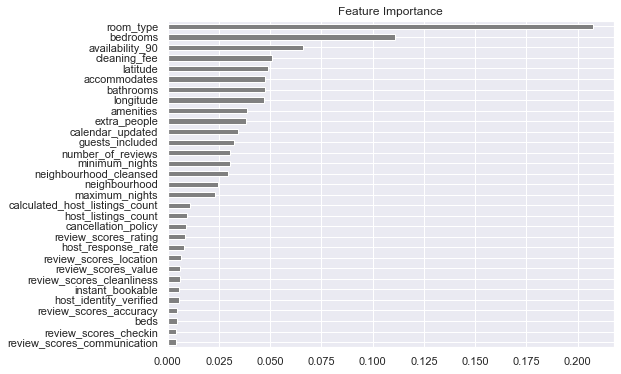

In [74]:

# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
importances.sort_values().plot.barh(color='grey');

#### XGBOOST Model

In [75]:
# FINAL XGBoost with hyper params and fitting on full data

gb_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    #SimpleImputer(strategy='median'),
    
    XGBRegressor(n_estimators=1000, learningrate=0.1, max_depth=3, max_features=20,
                 min_child_weight= 15, objective='reg:squarederror', random_state=42, n_jobs=-1)
    )

gb_pipeline.fit(X_train, y_train)
k = 5
scores = cross_val_score(gb_pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores.mean())

MAE for 5 folds: 15.465069504681983


In [76]:
y_pred = gb_pipeline.predict(X_test)
print('Gradient Boosting R^2:', r2_score(y_test, y_pred))

Gradient Boosting R^2: 0.6036451680927682


### Feature Importance

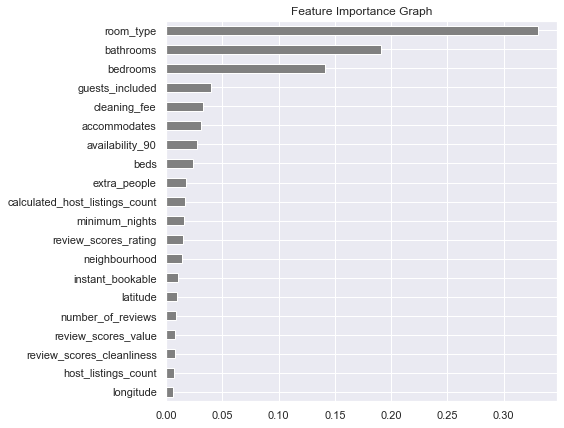

In [77]:
# Let's do a permutation importance to see just what the most important features are
%matplotlib inline
# Get feature importances
xgb_model =gb_pipeline.named_steps['xgbregressor']
xgb_encoder = gb_pipeline.named_steps['ordinalencoder']
importances = pd.Series(xgb_model.feature_importances_, X_train.columns)

# Plot feature importances
n=20
plt.figure(figsize=(7, 7))
plt.title('Feature Importance Graph')
importances.sort_values()[-n:].plot.barh(color='grey');

In [78]:
imp_columns = importances.sort_values()[-n:].index
imp_columns

Index(['longitude', 'host_listings_count', 'review_scores_cleanliness',
       'review_scores_value', 'number_of_reviews', 'latitude',
       'instant_bookable', 'neighbourhood', 'review_scores_rating',
       'minimum_nights', 'calculated_host_listings_count', 'extra_people',
       'beds', 'availability_90', 'accommodates', 'cleaning_fee',
       'guests_included', 'bedrooms', 'bathrooms', 'room_type'],
      dtype='object')

#### Permutation Importance

In [79]:
#How much the score decreases when a feature is not available.
import eli5
from eli5.sklearn import PermutationImportance

X_train_encoded =xgb_encoder.transform(X_train)
X_test_encoded = xgb_encoder.transform(X_test)

permuter = PermutationImportance(
    gb_pipeline,
    scoring='neg_mean_absolute_error',
    n_iter=10,
    random_state=42
)
permuter.fit(X_test_encoded, y_test)
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_test.columns.tolist()
)

C:\Users\deepa\Anaconda3\envs\unit2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\deepa\Anaconda3\envs\unit2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
1.6781 ± 0.2333,availability_90
1.2897 ± 0.0999,cleaning_fee
0.6834 ± 0.0853,minimum_nights
0.4815 ± 0.1144,extra_people
0.3814 ± 0.0846,latitude
0.3502 ± 0.0648,number_of_reviews
0.2025 ± 0.0842,guests_included
0.1799 ± 0.1560,longitude
0.0573 ± 0.0359,calculated_host_listings_count
0.0344 ± 0.0634,maximum_nights
